# Plots of Total Deaths in the UK

Raw data for the last ten years, starting from 2020, are downloaded from the [ONS](https://www.ons.gov.uk/) as excel files. Total death counts are then programatically extracted from these excel files and plotted, without any statistical chicanery.

Note that all the data downloaded are stored in the [git repository](https://github.com/rh-downunder/UK_COVID_mortality) that this notebook is a part of -- this is partly to keep a record of the underlying data, in case the ONS updates it retroactively.


In [28]:
"""
Description:
    Comparative plots of total deaths in the UK over the last ten years.

References:
    
CreationDate:   16/01/2021
Developer:      https://www.researchgate.net/profile/Rakib_Hassan2
"""

from openpyxl import load_workbook
import os
from xls2xlsx import XLS2XLSX # needed for converting xls files to xlsx
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import gridspec


## Download Data

In [2]:
# Download data from the ONS for deaths registered weekly in England and Wales
data_dict = {
    'd2010.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2010/publishedweek2010.xls',
    'd2011.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2011/publishedweek2011.xls',
    'd2012.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2012/publishedweek2012.xls',
    'd2013.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2013/publishedweek2013.xls',
    'd2014.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2014/publishedweek2014.xls',
    'd2015.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2015/publishedweek2015.xls',
    'd2016.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2016/publishedweek522016.xls',
    'd2017.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2017/publishedweek522017.xls',
    'd2018.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2018/publishedweek522018withupdatedrespiratoryrow.xls',
    'd2019.xls':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2019/publishedweek522019.xls',
    'd2020.xlsx':'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2020/publishedweek532020.xlsx',
}

# convert xls files to the more recent xlsx format for ease of data extraction
for fname in data_dict:
    r = requests.get(data_dict[fname], allow_redirects=True)
    open(fname, 'wb').write(r.content)
        
    if('xlsx' not in fname):
        print('Converting %s to xlsx format'%fname)
        x2x = XLS2XLSX(fname)
        x2x.to_xlsx(fname.split('.')[0] + '.xlsx')
        os.remove(fname)
# end for    

Converting d2010.xls to xlsx format
Converting d2011.xls to xlsx format
Converting d2012.xls to xlsx format
Converting d2013.xls to xlsx format
Converting d2014.xls to xlsx format
Converting d2015.xls to xlsx format
Converting d2016.xls to xlsx format
Converting d2017.xls to xlsx format
Converting d2018.xls to xlsx format
Converting d2019.xls to xlsx format


In [3]:
class YearlyData:
    """
    Excel worksheet parser for extracting relevant data.
    """
    def __init__(self, 
                 work_sheet=None, 
                 week_number_cells='',
                 week_ended_cells='', 
                 total_deaths_all_ages='',
                 age_groups_cells='', 
                 deaths_by_age_group_cells=''):
        """
        Note that we need explicit cell-ranges as they are not consistent
        across all years.
        """

        self.week_number = None
        self.week_ended = None
        self.total_deaths_all_ages = None
        self.age_groups = None
        self.deaths_by_age_group = None
        
        ranges_dict = {'week_number': week_number_cells, 
                       'week_ended': week_ended_cells, 
                       'total_deaths_all_ages': total_deaths_all_ages, 
                       'age_groups': age_groups_cells, 
                       'deaths_by_age_group': deaths_by_age_group_cells}
        
        for item in ranges_dict:
            self.__dict__[item] = []
            range_tokens = ranges_dict[item].split(':')
            for row in work_sheet[slice(range_tokens[0], range_tokens[1])]:
                cols = []
                for cell in row:
                    cols.append(cell.value)        
                # end for
                self.__dict__[item].append(cols)        
            # end for
            self.__dict__[item] = np.squeeze(np.array(self.__dict__[item]))
            #print (np.shape(self.__dict__[item]))
            #print(self.__dict__[item])
        # end for     
        
        #sanity checks
        assert(np.shape(self.week_number) == np.shape(self.week_ended))
        assert(np.shape(self.deaths_by_age_group) == 
               (np.shape(self.age_groups)[0], np.shape(self.week_number)[0]))
    # end func
# end class


## Extract Data from Excel Files

In [4]:
# Parse data from each year's excel file and store them in a dict.
# Cell-ranges for each year's data were collated manually.
data_dict = {}

d2020 = load_workbook(filename='d2020.xlsx', read_only=True)
data_dict[2020] = YearlyData(d2020['Weekly figures 2020'], 
                   week_number_cells='C5:BC5',
                   week_ended_cells='C6:BC6',
                   total_deaths_all_ages='C9:BC9',
                   age_groups_cells='B22:B41',
                   deaths_by_age_group_cells='C22:BC41')

d2019 = load_workbook(filename='d2019.xlsx', read_only=True)
data_dict[2019] = YearlyData(d2019['Weekly figures 2019'], 
                   week_number_cells='C4:BB4',
                   week_ended_cells='C5:BB5',
                   total_deaths_all_ages='C8:BB8',
                   age_groups_cells='B16:B22',
                   deaths_by_age_group_cells='C16:BB22')

d2018 = load_workbook(filename='d2018.xlsx', read_only=True)
data_dict[2018] = YearlyData(d2018['Weekly figures 2018'], 
                   week_number_cells='C4:BB4',
                   week_ended_cells='C5:BB5',
                   total_deaths_all_ages='C8:BB8',
                   age_groups_cells='B16:B22',
                   deaths_by_age_group_cells='C16:BB22')

d2017 = load_workbook(filename='d2017.xlsx', read_only=True)
data_dict[2017] = YearlyData(d2017['Weekly figures 2017'], 
                   week_number_cells='C4:BB4',
                   week_ended_cells='C5:BB5',
                   total_deaths_all_ages='C8:BB8',
                   age_groups_cells='B16:B22',
                   deaths_by_age_group_cells='C16:BB22')

d2016 = load_workbook(filename='d2016.xlsx', read_only=True)
data_dict[2016] = YearlyData(d2016['Weekly figures 2016'], 
                   week_number_cells='C4:BB4',
                   week_ended_cells='C5:BB5',
                   total_deaths_all_ages='C8:BB8',
                   age_groups_cells='B16:B22',
                   deaths_by_age_group_cells='C16:BB22')

d2015 = load_workbook(filename='d2015.xlsx', read_only=True)
data_dict[2015] = YearlyData(d2015['Weekly Figures 2015'], 
                   week_number_cells='B4:BB4',
                   week_ended_cells='B5:BB5',
                   total_deaths_all_ages='B8:BB8',
                   age_groups_cells='A16:A22',
                   deaths_by_age_group_cells='B16:BB22')

d2014 = load_workbook(filename='d2014.xlsx', read_only=True)
data_dict[2014] = YearlyData(d2014['Weekly Figures 2014'], 
                   week_number_cells='B3:BA3',
                   week_ended_cells='B4:BA4',
                   total_deaths_all_ages='B7:BA7',
                   age_groups_cells='A16:A22',
                   deaths_by_age_group_cells='B16:BA22')

d2013 = load_workbook(filename='d2013.xlsx', read_only=True)
data_dict[2013] = YearlyData(d2013['Weekly Figures 2013'], 
                   week_number_cells='B4:BA4',
                   week_ended_cells='B5:BA5',
                   total_deaths_all_ages='B8:BA8',
                   age_groups_cells='A16:A22',
                   deaths_by_age_group_cells='B16:BA22')

d2012 = load_workbook(filename='d2012.xlsx', read_only=True)
data_dict[2012] = YearlyData(d2012['Weekly Figures 2012'], 
                   week_number_cells='B4:BA4',
                   week_ended_cells='B5:BA5',
                   total_deaths_all_ages='B8:BA8',
                   age_groups_cells='A16:A22',
                   deaths_by_age_group_cells='B16:BA22')

d2011 = load_workbook(filename='d2011.xlsx', read_only=True)
data_dict[2011] = YearlyData(d2011['Weekly Figures 2011'], 
                   week_number_cells='B4:BA4',
                   week_ended_cells='B5:BA5',
                   total_deaths_all_ages='B8:BA8',
                   age_groups_cells='A17:A23',
                   deaths_by_age_group_cells='B17:BA23')

d2010 = load_workbook(filename='d2010.xlsx', read_only=True)
data_dict[2010] = YearlyData(d2010['Weekly Figures 2010'], 
                   week_number_cells='B4:BA4',
                   week_ended_cells='B5:BA5',
                   total_deaths_all_ages='B8:BA8',
                   age_groups_cells='A16:A22',
                   deaths_by_age_group_cells='B16:BA22')


In [5]:
# Font settings
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

# Plot weekly deaths for the last ten years

Lockdown start/end dates are as given on [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_lockdowns)


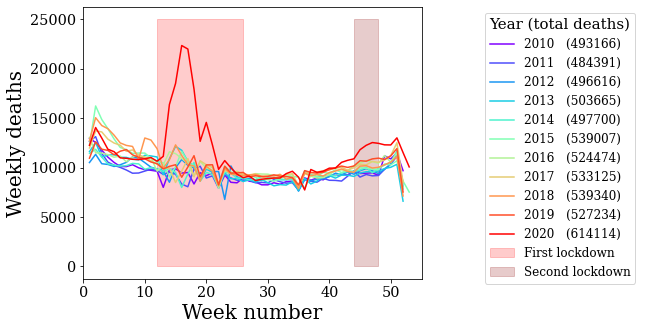

In [96]:
colors = cm.rainbow(np.linspace(0,1,len(data_dict)))

fig = plt.figure()
fig.set_size_inches((10,5))

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1])
ax = fig.add_subplot(spec[0])
lax = fig.add_subplot(spec[1])

for item,color in zip(sorted(data_dict.keys()), colors):
    ax.plot(data_dict[item].week_number, 
            data_dict[item].total_deaths_all_ages, c=color, 
            label='%d   (%d)'%(item, np.sum(data_dict[item].total_deaths_all_ages)))    
# end for

ax.fill_betweenx([0,25000], 12,26, color='r', alpha=0.2, label='First lockdown')
ax.fill_betweenx([0,25000], 44,48, color='darkred', alpha=0.2, label='Second lockdown')

ax.set_xlim([0,55])

ax.set_xlabel('Week number', fontsize=20)
ax.set_ylabel('Weekly deaths', fontsize=20)

h,l = ax.get_legend_handles_labels()
lax.legend(h,l, fontsize=12, title='Year (total deaths)', 
           title_fontsize=15)
lax.axis("off")

plt.savefig('Fig1.pdf', dpi=600)

# Plot 2020 Deaths by Age-group 

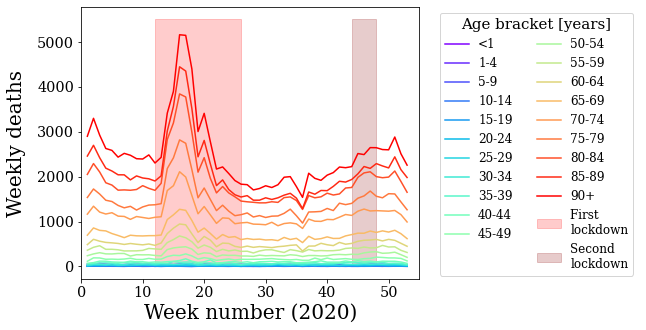

In [95]:
fig = plt.figure()
fig.set_size_inches((10,5))

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1])
ax = fig.add_subplot(spec[0])
lax = fig.add_subplot(spec[1])

colors = cm.rainbow(np.linspace(0,1,len(data_dict[2020].deaths_by_age_group)))
for i,color in zip(range(len(data_dict[2020].age_groups)), colors):
    ax.plot(data_dict[2020].week_number, 
            data_dict[2020].deaths_by_age_group[i,:], color=color,
            label=data_dict[2020].age_groups[i])
# end for

ax.fill_betweenx([0,5500], 12,26, color='r', alpha=0.2, label='First \nlockdown')
ax.fill_betweenx([0,5500], 44,48, color='darkred', alpha=0.2, label='Second \nlockdown')

ax.set_xlim([0,55])
ax.yaxis.labelpad = 11

ax.set_xlabel('Week number (2020)', fontsize=20)
ax.set_ylabel('Weekly deaths', fontsize=20)

h,l = ax.get_legend_handles_labels()
lax.legend(h,l, fontsize=12, ncol=2, 
          title='Age bracket [years]', title_fontsize=15)
lax.axis("off")

plt.savefig('Fig2.pdf', dpi=600)

# Total Excess Deaths in 2020

In [45]:
# compute average total deaths for the last five years preceding 2020.
avg_total_deaths_last_five_years =  int(np.mean( [np.sum(data_dict[2019].total_deaths_all_ages),
                                                  np.sum(data_dict[2018].total_deaths_all_ages),
                                                  np.sum(data_dict[2017].total_deaths_all_ages),
                                                  np.sum(data_dict[2016].total_deaths_all_ages),
                                                  np.sum(data_dict[2015].total_deaths_all_ages)] ))

# compute excess deaths in 2020, relative the average of the preceding 5 years.
excess_deaths_2020 = np.sum(data_dict[2020].total_deaths_all_ages) - avg_total_deaths_last_five_years

print(excess_deaths_2020)

81478


# Total Excess Deaths in 2020 by age-group (75+)

In [46]:
avg_total_deaths_last_five_years_75_plus = \
                np.int_(np.mean([np.sum(data_dict[2019].deaths_by_age_group[-2:,:]),
                np.sum(data_dict[2018].deaths_by_age_group[-2:,:]),
                np.sum(data_dict[2017].deaths_by_age_group[-2:,:]),
                np.sum(data_dict[2016].deaths_by_age_group[-2:,:]),
                np.sum(data_dict[2015].deaths_by_age_group[-2:,:])]))

# Note the indexing used here, compared to above: the ONS broke down the 2020 data into 
# 20 age-groups, whereas the data for the previous ten years are broken down into 7 age-groups
total_deaths_2020_75_plus = np.sum(data_dict[2020].deaths_by_age_group[-4:, :])

excess_deaths_2020_75_plus = total_deaths_2020_75_plus - avg_total_deaths_last_five_years_75_plus

print(excess_deaths_2020_75_plus)

59077


# Total Excess Deaths in 2020 by age-group (<45)

In [97]:
avg_total_deaths_last_five_years_below_45 = \
                np.int_(np.mean([np.sum(data_dict[2019].deaths_by_age_group[:3,:]),
                np.sum(data_dict[2018].deaths_by_age_group[:3,:]),
                np.sum(data_dict[2017].deaths_by_age_group[:3,:]),
                np.sum(data_dict[2016].deaths_by_age_group[:3,:]),
                np.sum(data_dict[2015].deaths_by_age_group[:3,:])]))

# Note the indexing used here, compared to above: the ONS broke down the 2020 data into 
# 20 age-groups, whereas the data for the previous ten years are broken down into 7 age-groups
total_deaths_2020_below_45 = np.sum(data_dict[2020].deaths_by_age_group[:10, :])

excess_deaths_2020_below_45 = total_deaths_2020_below_45 - avg_total_deaths_last_five_years_below_45

print(excess_deaths_2020_below_45)

299
